## Modeling 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectFromModel

import itertools
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier


In [2]:
data_dir = os.path.abspath(os.path.join('..', 'data'))
data = pd.read_csv(os.path.join(data_dir,'train.csv'))
data_dict = pd.read_csv(os.path.join(data_dir,'data_dictionary.csv'))
test_data = pd.read_csv(os.path.join(data_dir,'test.csv'))

In [3]:
# Saving test ids to a list to build test subsmissions after model.predict is run
test_ids = test_data["id"].tolist()

Load data, drop rows missing the target

In [4]:
data_OG = data
data_OG

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,4.0,2.0,4.0,55.0,NaN,NaN,NaN,Fall,3.0,2.0
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,0.0,0.0,0.0,Fall,46.0,64.0,Summer,0.0,0.0
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,2.0,1.0,1.0,28.0,Fall,38.0,54.0,Summer,2.0,0.0
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,3.0,4.0,1.0,44.0,Summer,31.0,45.0,Winter,0.0,1.0
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3955,ff8a2de4,Fall,13,0,Spring,60.0,Fall,16.362460,59.5,82.4,...,1.0,1.0,0.0,32.0,Winter,35.0,50.0,Fall,1.0,1.0
3956,ffa9794a,Winter,10,0,NaN,NaN,Spring,18.764678,53.5,76.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Winter,0.0,NaN
3957,ffcd4dbd,Fall,11,0,Spring,68.0,Winter,21.441500,60.0,109.8,...,1.0,0.0,1.0,31.0,Winter,56.0,77.0,Fall,0.0,1.0
3958,ffed1dd5,Spring,13,0,Spring,70.0,Winter,12.235895,70.7,87.0,...,1.0,1.0,1.0,19.0,Spring,33.0,47.0,Spring,1.0,0.0


In [5]:
# Step 3: Basic EDA
# Drop the 'id' column if it exists since it is not useful for analysis or modeling
if 'id' in data.columns:
    data = data.drop(columns=['id'])

# Drop PCIAT columns as they are the actual test and answers
drop_columns = [col for col in data.columns if col.startswith('PCIAT')]
data = data.drop(columns=drop_columns)

# Drop rows with missing target values
data = data.dropna(subset=['sii'])

# data.drop("sii",axis=1,inplace=True)

print("Shape with sii:",data.shape)
print("Num missing:",data.isna().sum().sum())


Shape with sii: (2736, 59)
Num missing: 51701


In [6]:
data

,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,...,PAQ_A-Season,PAQ_A-PAQ_A_Total,PAQ_C-Season,PAQ_C-PAQ_C_Total,SDS-Season,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fall,3.0,2.0
1,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,22.0,...,NaN,NaN,Fall,2.340,Fall,46.0,64.0,Summer,0.0,0.0
2,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,NaN,...,NaN,NaN,Summer,2.170,Fall,38.0,54.0,Summer,2.0,0.0
3,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,NaN,...,NaN,NaN,Winter,2.451,Summer,31.0,45.0,Winter,0.0,1.0
5,Spring,13,1,Winter,50.0,Summer,22.279952,59.5,112.2,NaN,...,NaN,NaN,Spring,4.110,Summer,40.0,56.0,Spring,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3953,Fall,8,0,NaN,NaN,Fall,17.139810,52.5,67.2,25.0,...,NaN,NaN,Fall,3.440,Fall,41.0,58.0,Fall,2.0,0.0
3954,Summer,7,1,NaN,NaN,Summer,13.927006,48.5,46.6,23.0,...,NaN,NaN,NaN,NaN,Summer,48.0,67.0,Summer,0.0,1.0
3955,Fall,13,0,Spring,60.0,Fall,16.362460,59.5,82.4,NaN,...,NaN,NaN,Winter,3.260,Winter,35.0,50.0,Fall,1.0,1.0
3957,Fall,11,0,Spring,68.0,Winter,21.441500,60.0,109.8,NaN,...,NaN,NaN,Winter,2.729,Winter,56.0,77.0,Fall,0.0,1.0


## EDA

Basic imputation:

In [7]:
# combined fitness endurance time column
data["Fitness_Endurance-Time_Sec"].fillna(0)
data["Fitness_Endurance-Time"] = 60*data["Fitness_Endurance-Time_Mins"] + \
    data["Fitness_Endurance-Time_Sec"]
data.drop(columns=["Fitness_Endurance-Time_Mins","Fitness_Endurance-Time_Sec"],inplace=True)

# combined PAQ: usually only child or adult filled in, so make a combined column
data['PAQ'] = data['PAQ_A-PAQ_A_Total'].fillna(data['PAQ_C-PAQ_C_Total'])
data.drop('PAQ_A-PAQ_A_Total',axis=1,inplace=True)
data.drop('PAQ_C-PAQ_C_Total',axis=1,inplace=True)

# fill in BMI
data['calc-BMI'] = data['Physical-Weight']*0.453592 / (data['Physical-Height']*0.0254)**2
                        #weight kg/height m squared
data['Physical-BMI'] = data['Physical-BMI'].fillna(data['calc-BMI'])
data['Physical-BMI'] = data['Physical-BMI'].fillna(data['BIA-BIA_BMI'])
data['BIA-BIA_BMI'] = data['BIA-BIA_BMI'].fillna(data['Physical-BMI'])
data.drop('Physical-Height',axis=1,inplace=True)
data.drop('Physical-Weight',axis=1,inplace=True)
data.drop('calc-BMI',axis=1,inplace=True)

print("Shape with sii:",data.shape)
print("Num missing:",data.isna().sum().sum())

Shape with sii: (2736, 55)
Num missing: 45863


Remove BIA outliers/unreasonable values

In [8]:
# fix BIA outliers
# note: reasonable values were determined by looking at histogram plots of the fields,
# for various bin sizes until it was apparent which were outliers
# extension: use outlier detection algorithm instead of hand-crafted cutoffs
data['BIA-BIA_BMC'] = data['BIA-BIA_BMC'].mask(data['BIA-BIA_BMC'] > 20, pd.NA)
data['BIA-BIA_BMR'] = data['BIA-BIA_BMR'].mask(data['BIA-BIA_BMR'] > 2500, pd.NA)
data['BIA-BIA_DEE'] = data['BIA-BIA_DEE'].mask(data['BIA-BIA_DEE'] > 4000, pd.NA)
data['BIA-BIA_ECW'] = data['BIA-BIA_ECW'].mask(data['BIA-BIA_ECW'] > 80, pd.NA)
data['BIA-BIA_FFM'] = data['BIA-BIA_FFM'].mask(data['BIA-BIA_FFM'] > 200, pd.NA)
data['BIA-BIA_FFMI'] = data['BIA-BIA_FFMI'].mask(data['BIA-BIA_FFMI'] > 25, pd.NA)
data['BIA-BIA_FMI'] = data['BIA-BIA_FMI'].mask(data['BIA-BIA_FMI'] < 0, pd.NA)
data['BIA-BIA_Fat'] = data['BIA-BIA_Fat'].mask(data['BIA-BIA_Fat'] < 0, pd.NA)
data['BIA-BIA_Fat'] = data['BIA-BIA_Fat'].mask(data['BIA-BIA_Fat'] > 100, pd.NA)
data['BIA-BIA_ICW'] = data['BIA-BIA_ICW'].mask(data['BIA-BIA_ICW'] > 100, pd.NA)
data['BIA-BIA_LDM'] = data['BIA-BIA_LDM'].mask(data['BIA-BIA_LDM'] > 50, pd.NA)
data['BIA-BIA_LST'] = data['BIA-BIA_LST'].mask(data['BIA-BIA_LST'] > 150, pd.NA)
data['BIA-BIA_SMM'] = data['BIA-BIA_SMM'].mask(data['BIA-BIA_SMM'] > 100, pd.NA)
data['BIA-BIA_TBW'] = data['BIA-BIA_TBW'].mask(data['BIA-BIA_TBW'] > 125, pd.NA)

print("Shape with sii:",data.shape)
print("Num missing:",data.isna().sum().sum())

Shape with sii: (2736, 55)
Num missing: 46092


Drop fitnessgram zones (redundant info)

In [9]:
# drop FitnessGram zones
data.drop([col for col in data.columns if '_Zone' in col],axis=1,inplace=True)

print("Shape with sii:",data.shape)
print("Num missing:",data.isna().sum().sum())

Shape with sii: (2736, 48)
Num missing: 38068


Drop low correlation features

Shape with sii: (2736, 37)
Num missing: 28349


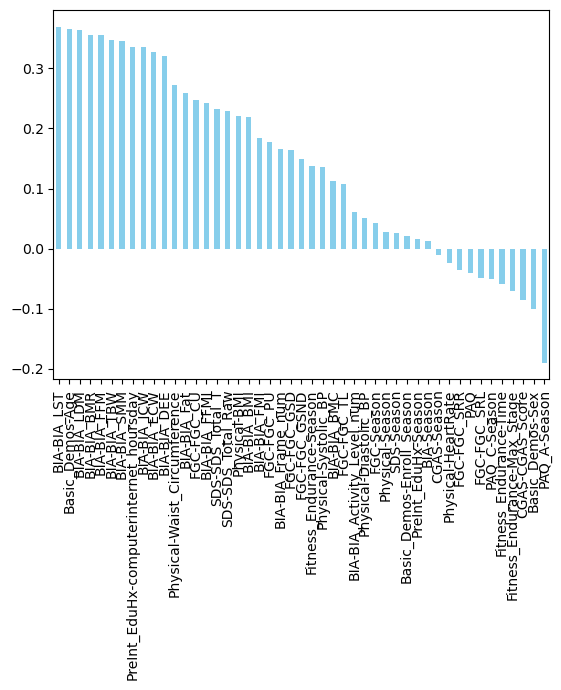

In [10]:


# Convert categorical features to numeric using label encoding for correlation analysis
cat_features = data.select_dtypes(include=['object']).columns
le = LabelEncoder()
for col in cat_features:
    data[col] = le.fit_transform(data[col].astype(str))

# # Visualize the distribution of the target variable ('sii')
# sns.countplot(x='sii', data=data)
# plt.title('Distribution of Target Variable')
# plt.show()

# Correlation bar chart of features to 'sii'
correlation = data.corr()['sii'].drop('sii').sort_values(ascending=False)
# plt.figure(figsize=(12, 8))
correlation.plot(kind='bar', color='skyblue')
# plt.title('Correlation of Features with Target Variable (sii)')
# plt.xlabel('Features')
# plt.ylabel('Correlation Coefficient')
# plt.show()

# Drop low correlation features (threshold set at |correlation| < 0.05)
low_correlation_features = correlation[abs(correlation) < 0.05].index
data = data.drop(columns=low_correlation_features)

# # Visualize distributions of numerical features
# data.hist(bins=20, figsize=(20, 15))
# plt.tight_layout()
# plt.show()

# Visualize relationships between features and target using pairplot
high_corr_features = correlation[abs(correlation) >= 0.05].index.tolist()
# sns.pairplot(data, hue='sii', vars=high_corr_features[:5])  # Include a subset of top correlated features
# plt.show()

print("Shape with sii:",data.shape)
print("Num missing:",data.isna().sum().sum())

## Feature Engineering 

### KNN Imputation

For fields where over half of data is missing, fill with average (median for num, mode for cat)

In [11]:
# identify columns where at least half of data is missing
is_missing = data.isna().mean(axis=0).to_frame().sort_values(by=0,ascending=False)
sparse_columns = is_missing[is_missing > 0.5].dropna().index
sparse_columns

# fill in sparse columns with median/mode
data_ref = data.copy()

# Fill missing values for numerical features with the median
num_features = data.select_dtypes(include=['float64', 'int64']).columns
num_features = [col for col in num_features if col in sparse_columns]
med_vals = data_ref.loc[:,num_features].median()
data[num_features] = data[num_features].fillna(med_vals)

# Fill missing values for categorical features with the mode
cat_features = data.select_dtypes(include=['object']).columns
cat_features = [col for col in cat_features if col in sparse_columns]
if len(cat_features) > 0:
    for col in cat_features:
        mode_value = data_ref.loc[:,col].mode()
        if len(mode_value) > 0:
            data[col].fillna(mode_value.iloc[0], inplace=True)

print("Shape with sii:",data.shape)
print("Num missing:",data.isna().sum().sum())

Shape with sii: (2736, 37)
Num missing: 18353


Knn imputation

In [12]:
# for the rest of the features, use knn imputation
data.reset_index(inplace=True,drop=True)
data_ref = data.copy()

# define column groups
cols = list(data.columns)
col_groups = {}

tests = ["Basic_Demos","CGAS","Physical","Fitness_Endurance","FGC","BIA","PAQ","SDS","PreInt"]
for test in tests:
    col_groups[test] = [col for col in data.columns if test in col]

print(col_groups)

feat_cols = list(itertools.chain.from_iterable(col_groups.values()))
print(feat_cols)

N = 3

for idx in range(data.shape[0]):
    item = data.loc[[idx]]
    sii = item.sii.values[0]
    item = item[feat_cols]

    is_missing = item.isnull().any()
    missing_cols = is_missing[is_missing].index.tolist()
    feat_data = item.dropna(axis=1)

    for col in missing_cols:
        use_me = [col for col in feat_data.columns if col in data_ref.columns] + [col]
        feat_ref = data_ref.loc[:, use_me].dropna()
        if feat_ref.shape[0] == 0:
            print("No data")
        if feat_ref.shape[0] < 5:
            print('!!!')
            continue
        x = feat_ref[list(feat_data.columns)]
        y = feat_ref[col]
        if col in ['PAQ','Fitness_Endurance-Time']:
            knn = KNeighborsRegressor(n_neighbors=N)
        elif 'categorical' in data_dict.Type[data_dict.Field == col].values[0]:
            knn = KNeighborsClassifier(n_neighbors=N)
        else:
            knn = KNeighborsRegressor(n_neighbors=N)
        knn.fit(x,y.values)
        y_fill = knn.predict(feat_data)
        data.loc[idx,col] = y_fill

print("Shape with sii:",data.shape)
print("Num missing:",data.isna().sum().sum())

{'Basic_Demos': ['Basic_Demos-Age', 'Basic_Demos-Sex'], 'CGAS': ['CGAS-CGAS_Score'], 'Physical': ['Physical-BMI', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-Systolic_BP'], 'Fitness_Endurance': ['Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time'], 'FGC': ['FGC-FGC_CU', 'FGC-FGC_GSND', 'FGC-FGC_GSD', 'FGC-FGC_PU', 'FGC-FGC_TL'], 'BIA': ['BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW'], 'PAQ': ['PAQ_A-Season', 'PAQ_C-Season'], 'SDS': ['SDS-SDS_Total_Raw', 'SDS-SDS_Total_T'], 'PreInt': ['PreInt_EduHx-computerinternet_hoursday']}
['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI', 'Physical-Waist_Circumference', 'Physical-Diastolic_BP', 'Physical-Systolic_BP', 'Fitness_Endurance-Season', 'Fitness_Enduran

Convert categorical to dummies

In [13]:
# convert categorical variables to dummies
to_dummies = (data.columns.intersection(data_dict.Field[data_dict.Type == "categorical int"]))
to_dummies = [d for d in to_dummies if "Sex" not in d]
for col in to_dummies:
    dummies = pd.get_dummies(data[col],prefix=col).astype(int)
    data = pd.concat([data, dummies], axis=1)
data.drop(to_dummies,axis=1,inplace=True)

print("Shape with sii:",data.shape)
print("Num missing:",data.isna().sum().sum())

Shape with sii: (2736, 46)
Num missing: 0


Add polynomial features

In [14]:
# Step 4: Feature Engineering
# Add polynomial features to capture non-linear relationships
poly = PolynomialFeatures(degree=2, include_bias=False)
use_me = [col for col in high_corr_features if col not in to_dummies and col in data.columns]
poly_features = poly.fit_transform(data[use_me])
poly_feature_names = [f'poly_{name}' for name in poly.get_feature_names_out(use_me)]
poly_df = pd.DataFrame(poly_features, columns=poly_feature_names, index=data.index)

# Ensure no duplicate columns before concatenation
poly_df = poly_df.loc[:, ~poly_df.columns.duplicated()]

# Concatenate polynomial features with original data
data = pd.concat([data, poly_df], axis=1)

# Drop duplicate columns if any
data = data.loc[:, ~data.columns.duplicated()]

print("Shape with sii:",data.shape)
print("Num missing:",data.isna().sum().sum())

Shape with sii: (2736, 640)
Num missing: 0


From modeling notebook: feature selection decision tree chose 320 features